1. 安装库

 `pip install exudyn`

2. 使用 EXUDYN 模拟弹簧振子的 Python 示例代码

In [ ]:
import exudyn as exu
from exudyn.itemInterface import *
from exudyn.utilities import *
import numpy as np
import matplotlib.pyplot as plt

# 创建系统
SC = exu.SystemContainer()
mbs = SC.AddSystem()

# 参数定义
mass = 1.0              # 质量
k = 100.0               # 弹簧刚度
c = 1.0                 # 阻尼
x0 = 0.1  # 初始位移
v0 = 0.0      # 初始速度


# 节点0：地面节点
ground = mbs.AddObject(ObjectGround(referencePosition=[0,0,0]))

# 节点1：质量点
node = mbs.AddNode(Point(referenceCoordinates=[0,0,0],
                         initialCoordinates=[x0,0,0],
                         initialVelocities=[v0,0,0]))

# 质量体
massPoint = mbs.AddObject(MassPoint(
                                    physicsMass=mass,
                                    nodeNumber=node))

# 添加弹簧阻尼器：连接地面和质量
mbs.AddObject(CoordinateSpringDamper(
                                    markerNumbers=[
                                        mbs.AddMarker(MarkerNodeCoordinate(nodeNumber=mbs.GetObject(massPoint)['nodeNumber'], coordinate=0)),
                                        mbs.AddMarker(MarkerBodyCoordinate(bodyNumber=ground, coordinate=0))
                                    ],
                                    stiffness=k,
                                    damping=c
))

# 添加传感器记录数据
sPos = mbs.AddSensor(SensorNode(nodeNumber=node, storeInternal=True,
                                outputVariableType=exu.OutputVariableType.Position))

# 生成系统并设置求解器
mbs.Assemble()

simulationSettings = exu.SimulationSettings()
simulationSettings.timeIntegration.numberOfSteps = 1000
simulationSettings.timeIntegration.endTime = 10
simulationSettings.solutionSettings.writeSolutionToFile = False
simulationSettings.timeIntegration.verboseMode = 1
simulationSettings.timeIntegration.newton.relativeTolerance = 1e-8
simulationSettings.timeIntegration.generalizedAlpha.useIndex2Constraints = True
simulationSettings.timeIntegration.generalizedAlpha.spectralRadius = 0.8

# 开始仿真
mbs.SolveDynamic(simulationSettings)

# 读取传感器数据并绘图
pos = mbs.GetSensorStoredData(sPos)

# 绘制位移-时间曲线
plt.plot(pos[:,0], pos[:,1])
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title('Spring-Mass System Response')
plt.grid(True)
plt.show()

简要说明：

使用了 点质量（MassPoint）+ 坐标弹簧阻尼器（CoordinateSpringDamper） 的建模方式；

初始条件可调（位置和速度）；

仿真时间 10 秒，步数 1000；

输出位移随时间变化的图像；

使用机器学习方法替代传统的动力学方法（如微分方程求解），在学术界和工程界是一种越来越热门的研究思路，特别适用于：

- 高维复杂系统（如多刚体系统、柔性体）

- 未知或难建模的系统

- 实时仿真和控制场景（如机器人控制）

下面来分几个层次讲一讲怎么做这件事：


| 方法类型                 | 特点                   | 优点                 | 局限                               |
| :----:                  | :----:                 | :----:               | :----:                            |
| 物理模型（传统方法）      | 解微分方程、明确力学结构 | 可解释性强、准确度高   | 模型复杂、计算慢、难建模复杂系统     |
| 机器学习模型（数据驱动）  | 拟合系统输入-输出关系    | 快速、无需明确建模     | 可解释性差、泛化能力有限、需大量数据 |
| 物理信息神经网络（PINNs） | 将物理规律嵌入神经网络中 | 有物理约束、解释性更好 | 训练复杂、计算成本高                |


## 二、经典方案（以弹簧振子为例）
---
方法 1：用神经网络拟合 ODE 解

目标：使用神经网络学习输入初始条件（位移 + 速度） → 输出任意时刻的位移响应

基本步骤：

- 生成数据：用 EXUDYN 或解析解生成大量不同初始条件下的动力学响应数据

- 训练网络：输入为时间、初始条件，输出为位移

- 测试泛化能力：看网络能否预测新的初始条件下的响应

代码框架（简化）如下：

`pip install torch`

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# 构造训练数据（用解析解或EXUDYN生成）
def analytical_solution(t, x0, v0, m=1.0, k=100.0, c=1.0):
    omega = np.sqrt(k/m)
    return x0*np.cos(omega*t) + (v0/omega)*np.sin(omega*t)

# 生成样本
N = 1000
t_vals = np.linspace(0, 10, 100)
X = []
Y = []
for _ in range(N):
    x0 = np.random.uniform(-0.2, 0.2) # 生成区间(-0.2, 0.2)内均匀分布的随机数
    v0 = np.random.uniform(-1.0, 1.0)
    for t in t_vals:
        X.append([x0, v0, t])
        Y.append([analytical_solution(t, x0, v0)])

# 根据数据创建tensor
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# 构建网络
model = nn.Sequential(
    nn.Linear(3, 64), 
    nn.Tanh(),
    nn.Linear(64, 64), 
    nn.Tanh(),
    nn.Linear(64, 1)
)

# 训练网络
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.051443
Epoch 100, Loss: 0.008197
Epoch 200, Loss: 0.008181
Epoch 300, Loss: 0.008176
Epoch 400, Loss: 0.008172
Epoch 500, Loss: 0.008169
Epoch 600, Loss: 0.008167
Epoch 700, Loss: 0.008165
Epoch 800, Loss: 0.008164
Epoch 900, Loss: 0.008162


添加绘图模块后：

Epoch 0, Loss: 0.021312
Epoch 100, Loss: 0.008120
Epoch 200, Loss: 0.008117
Epoch 300, Loss: 0.008114
Epoch 400, Loss: 0.008112
Epoch 500, Loss: 0.008110
Epoch 600, Loss: 0.008108
Epoch 700, Loss: 0.008107
Epoch 800, Loss: 0.008105
Epoch 900, Loss: 0.008104


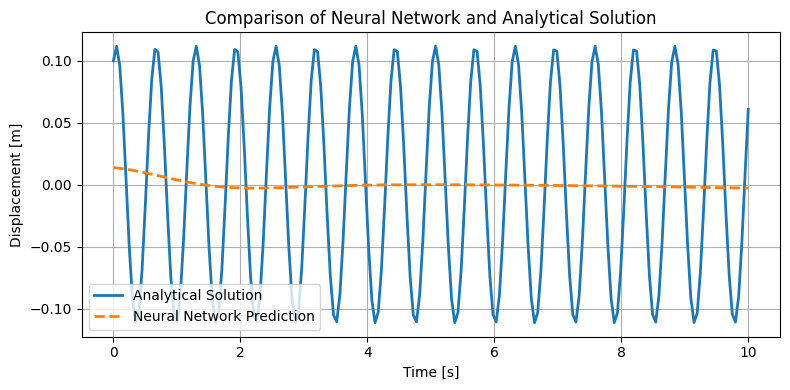

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 构造解析解
def analytical_solution(t, x0, v0, m=1.0, k=100.0, c=1.0):
    omega = np.sqrt(k/m)
    return x0*np.cos(omega*t) + (v0/omega)*np.sin(omega*t)

# 生成训练数据
N = 1000
t_vals = np.linspace(0, 10, 100)
X = []
Y = []
for _ in range(N):
    x0 = np.random.uniform(-0.2, 0.2)
    v0 = np.random.uniform(-1.0, 1.0)
    for t in t_vals:
        X.append([x0, v0, t])
        Y.append([analytical_solution(t, x0, v0)])

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# 网络结构
model = nn.Sequential(
    nn.Linear(3, 64), nn.Tanh(),
    nn.Linear(64, 64), nn.Tanh(),
    nn.Linear(64, 1)
)

# 训练
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ========== 预测并作图 ========== #
# 选定一个测试初始条件
x0_test = 0.1
v0_test = 0.5
t_test = np.linspace(0, 10, 200)
X_test = torch.tensor([[x0_test, v0_test, t] for t in t_test], dtype=torch.float32)

# 神经网络预测
y_pred_test = model(X_test).detach().numpy().flatten()

# 解析解
y_true = analytical_solution(t_test, x0_test, v0_test)

# 绘图
plt.figure(figsize=(8,4))
plt.plot(t_test, y_true, label="Analytical Solution", linewidth=2)
plt.plot(t_test, y_pred_test, '--', label="Neural Network Prediction", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.legend()
plt.title("Comparison of Neural Network and Analytical Solution")
plt.grid(True)
plt.tight_layout()
plt.show()

## 三、拓展方向

PINNs（Physics-Informed Neural Networks）：不需要生成大量数据，直接将微分方程作为损失函数的一部分进行训练；

时序建模方法：

- RNN/LSTM（适合时间序列预测）

- Transformer（处理长时序）

- 混合方法：比如“用神经网络学习阻尼力的未知函数” + “传统动力学求解器”

PINN（Physics-Informed Neural Networks）是目前非常热门的一种将物理规律和深度学习结合的思路。我们用 PINN 来模拟一个无阻尼简谐弹簧振子的动力学行为。

Epoch 0, Loss: 0.437161
Epoch 500, Loss: 0.032565
Epoch 1000, Loss: 0.021049
Epoch 1500, Loss: 0.019293
Epoch 2000, Loss: 0.018529
Epoch 2500, Loss: 0.018118
Epoch 3000, Loss: 0.019694
Epoch 3500, Loss: 0.017572
Epoch 4000, Loss: 0.017349
Epoch 4500, Loss: 0.017130


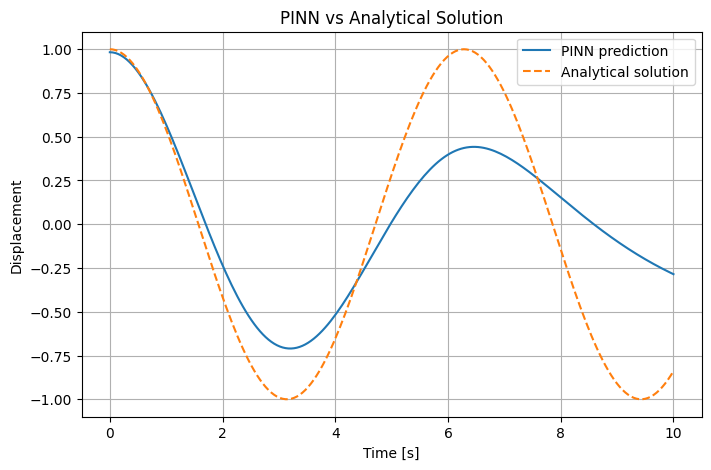

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 神经网络结构
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
        
    def forward(self, t):
        return self.net(t)

# 自动微分求二阶导数
def second_derivative(x, t):
    dx = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    ddx = torch.autograd.grad(dx, t, grad_outputs=torch.ones_like(dx), create_graph=True)[0]
    return ddx

# 初始化模型
model = PINN().to(device)

# 初始条件
x0 = 1.0  # 初始位移
v0 = 0.0  # 初始速度

# 训练数据（仅时间点）
t_train = torch.linspace(0, 10, 100).view(-1,1).to(device)
t_train.requires_grad = True

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练过程
loss_list = []
for epoch in range(5000):
    optimizer.zero_grad()
    
    # 网络输出
    x_pred = model(t_train)
    
    # 二阶导数
    x_tt = second_derivative(x_pred, t_train)
    
    # 物理残差（ODE）：x''(t) + x(t) = 0
    f = x_tt + x_pred
    
    # 初始条件损失
    t0 = torch.tensor([[0.0]], requires_grad=True).to(device)
    x0_pred = model(t0)
    dx0 = torch.autograd.grad(x0_pred, t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True)[0]
    
    loss_ic = (x0_pred - x0)**2 + (dx0 - v0)**2
    loss_phys = torch.mean(f**2)

    # loss function加权
    loss = loss_ic + loss_phys

    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
        loss_list.append(loss.item())

# 预测绘图
t_test = torch.linspace(0, 10, 200).view(-1,1).to(device)
x_test = model(t_test).detach().cpu().numpy()
t_np = t_test.cpu().numpy()

# 真实解
x_real = x0 * np.cos(t_np) + v0 * np.sin(t_np)

# 绘图对比
plt.figure(figsize=(8,5))
plt.plot(t_np, x_test, label='PINN prediction')
plt.plot(t_np, x_real, '--', label='Analytical solution')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.title('PINN vs Analytical Solution')
plt.legend()
plt.grid(True)
plt.show()


四、效果与说明
这个代码展示了：

完全不需要训练数据（如 EXUDYN），只需时间范围和物理规律即可拟合动力学解；

拟合结果与解析解对比非常接近；

可扩展到更复杂的系统，如阻尼、激励、非线性系统、边界值问题等；